# Filmic devblog 1: film grain and halation

In this devblog, we cover testing the concepts behind Filmic's features in Python. We'll be applying functions to alter images in a pleasing way, and confirming these ideas work before we try building UI and GPU shader code around them.

## Quick background and goals

This is a direct continuation of the last blog, where we used interpolated functions to generate a tone curve and color response for the image. Now, we'll be adding film grain and halation.

## The code

Let's get started with our imports and some setup.

In [2]:
# standard numpy and typing
import numpy as np
# image read, write, and conversion tools
import cv2
from PIL import Image

# to generate our cubic interpolation functions
from scipy.interpolate import interp1d

# nice image and plot display in our notebook
import matplotlib.pyplot as plt # for our image output

import plotly.graph_objects as go # for our plots, because plotly is awesome

# to generate simplex noise for fake film grain
# gives unresolved import error in  VS Code Jupyter notebook, but it still works
from opensimplex import noise2array 

# to apply gaussian blur for halation
from scipy.ndimage import gaussian_filter

# makes the size of our images a bit bigger in our notebook.
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

And now some reusable visualization functions now so we don't clog up our code blocks later. The logic behind these isn't really important.

In [3]:
def read_img(filename):
	'''reads a local image file and returns its data as a numpy float32 ndarray.

	Note that the read pixel values are normalized between 0.0 and 1.0, i.e. they are not uint8!
	'''
	return np.array(Image.open(filename)).astype(np.float32) / 255 

def write_img(img, filename):
	'''input img should be float.'''
	Image.fromarray((img * 255).astype('uint8')).save(filename)

def show_img_rgb(img_rgb):
	'''shows RGB image. hides ugly default matplotlib axes'''
	plt.axis('off')
	plt.gcf().set_facecolor("#0f0f0f")
	plt.imshow(np.clip(img_rgb, 0, 1))

def show_img_gray(img_gray):
	'''shows grayscale image. hides ugly default matplotlib axes'''
	plt.axis('off')
	plt.gcf().set_facecolor("#0f0f0f")
	plt.imshow(np.clip(img_gray, 0, 1), cmap='gray')

def show_img_left_right(img_left, img_right):
	'''display images beside each other'''
	fig, axarr = plt.subplots(1,2)
	fig.set_facecolor('#0f0f0f')
	fig.subplots_adjust(wspace = 0.03)
	axarr[0].imshow(img_left)
	axarr[0].axis('off')
	axarr[1].imshow(img_right)
	axarr[1].axis('off')

def plot_tone_curve(y_data, f_interp, label='tone'):
	'''plots tone curve with its interp function'''
	fig = go.Figure()
	fig.add_trace(
		go.Scatter(
			x = [0.0, 0.25, 0.5, 0.75, 1.0],
			y = y_data,
			mode ='markers',
			name = 'data',
			marker_color = 'hotpink',
			marker_size = 10
		)
	)

	x_curve = np.linspace(0.0, 1.0, num=100)

	fig.add_trace(
		go.Scatter(
			x = x_curve,
			y = f_interp(x_curve),
			name = 'interp',
			line_color = 'skyblue',
			line_width = 3,
		)
	)

	fig.update_layout(
		title = "tone curve",
		xaxis = dict(
			title = 'input tone',
			range = [-0.1, 1.1],
			dtick = 0.25
		),
		yaxis = dict(
			title = 'output ' + label,
			range = [-0.1, 1.1],
			dtick = 0.25
		),
		margin = dict(
			t = 40,
			b = 20,
			l = 20,
			r = 20
		)
	)

	fig.layout.template = 'plotly_dark'
	
	fig.show()

def plot_thresh_curve(x_data, y_data, f_interp):
	'''plots threshold curve with its interp function'''
	fig = go.Figure()
	fig.add_trace(
		go.Scatter(
			x = x_data,
			y = y_data,
			mode ='markers',
			name = 'data',
			marker_color = 'hotpink',
			marker_size = 10
		)
	)

	x_curve = np.linspace(0.0, 1.0, num=100)

	fig.add_trace(
		go.Scatter(
			x = x_curve,
			y = f_interp(x_curve),
			name = 'interp',
			line_color = 'skyblue',
			line_width = 3,
		)
	)

	fig.update_layout(
		title = "threshold curve",
		xaxis = dict(
			title = 'input',
			range = [-0.1, 1.1],
			dtick = 0.25
		),
		yaxis = dict(
			title = 'output',
			range = [-0.1, 1.1],
			dtick = 0.25
		),
		margin = dict(
			t = 40,
			b = 20,
			l = 20,
			r = 20
		)
	)

	fig.layout.template = 'plotly_dark'
	
	fig.show()

def rgb_to_hls(img_rgb):
	'''convert RGB to HLS. H is float in range of 0 to 360! H and S are 0.0 to 1.0'''
	return cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)

def hls_to_rgb(img_hls):
	'''convert HLS to RGB. H is float in range of 0 to 360! H and S are 0.0 to 1.0'''
	return cv2.cvtColor(img_hls, cv2.COLOR_HLS2RGB)

We'll start with adding tone-responsive granular noise to our image.

Two well known algorithms come to mind for synthesis of granular noise (both invented by the same person!), Perlin and Simplex noise. [This is a nice blog post](https://www.bit-101.com/blog/2021/07/perlin-vs-simplex/) that goes into their differences a bit. Most importantly for us, I found that Simplex noise,

1. matches the look of film grain better
2. just had its patent expire

Let's consider how we can adjust some parameters in our noise generation,

- `grain_size`: to zoom in and out of the noise pattern; lets us emulate granule size
- `intensity`: amplifies the noise and makes the transitions less smooth and more contrasty
- `offset`: adjusts the mean (center value) of the noise

Our usage can be abstracted to

$$ \mathrm{simplex}(\mathrm{size}) \times \mathrm{intensity} + \mathrm{offset}$$

Mind that when the image is rasterized, the values will be clamped between 0.0 and 1.0. We should look at examples with different argument values first to see what would best suit our needs.

Text(0.5, 1.0, 'offset = 1.0')

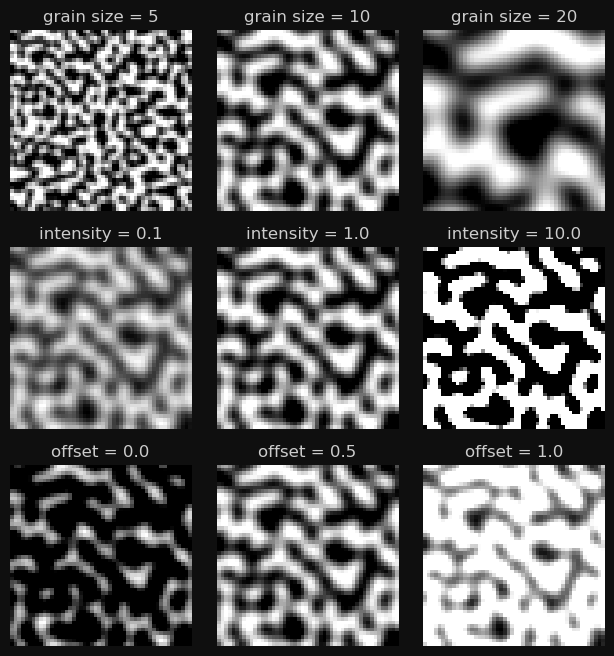

In [10]:
def grain_array(size, intensity, offset):
	'''generates a 50x50 array of simplex noise'''
	return noise2array(np.linspace(0, 100 / size, num=50), np.linspace(0, 100 / size, num=50)) * intensity + offset 

# # # visualization code # # #
# output at different argument values. The middle values remains constant between tests
fig, axarr = plt.subplots(3,3)

axarr[0, 0].imshow(np.clip(grain_array(  5,  1.0,  0.5 ), 0.0, 1.0), cmap='gray')
axarr[0, 1].imshow(np.clip(grain_array( 10,  1.0,  0.5 ), 0.0, 1.0), cmap='gray')
axarr[0, 2].imshow(np.clip(grain_array( 20,  1.0,  0.5 ), 0.0, 1.0), cmap='gray')

axarr[1, 0].imshow(np.clip(grain_array( 10,  0.1,  0.5 ), 0.0, 1.0), cmap='gray')
axarr[1, 1].imshow(np.clip(grain_array( 10,  1.0,  0.5 ), 0.0, 1.0), cmap='gray')
axarr[1, 2].imshow(np.clip(grain_array( 10, 10.0,  0.5 ), 0.0, 1.0), cmap='gray')

axarr[2, 0].imshow(np.clip(grain_array( 10,  1.0,  0.0  ), 0.0, 1.0), cmap='gray')
axarr[2, 1].imshow(np.clip(grain_array( 10,  1.0,  0.5  ), 0.0, 1.0), cmap='gray')
axarr[2, 2].imshow(np.clip(grain_array( 10,  1.0,  1.0  ), 0.0, 1.0), cmap='gray')

# make it pretty
fig.set_facecolor('#0f0f0f')
fig.subplots_adjust(wspace = -0.6)

axarr[0, 0].axis('off'); axarr[0, 0].set_title('grain size = 5', color='#CCCCCC') 
axarr[0, 1].axis('off'); axarr[0, 1].set_title('grain size = 10', color='#CCCCCC')
axarr[0, 2].axis('off'); axarr[0, 2].set_title('grain size = 20', color='#CCCCCC')

axarr[1, 0].axis('off'); axarr[1, 0].set_title('intensity = 0.1', color='#CCCCCC')
axarr[1, 1].axis('off'); axarr[1, 1].set_title('intensity = 1.0', color='#CCCCCC') 
axarr[1, 2].axis('off'); axarr[1, 2].set_title('intensity = 10.0', color='#CCCCCC')

axarr[2, 0].axis('off'); axarr[2, 0].set_title('offset = 0.0', color='#CCCCCC')
axarr[2, 1].axis('off'); axarr[2, 1].set_title('offset = 0.5', color='#CCCCCC')
axarr[2, 2].axis('off'); axarr[2, 2].set_title('offset = 1.0', color='#CCCCCC')

Now we have a better sense of what the granular noise looks like. Let's choose some values for our parameters and make an array big enough for our test image. This may take a few seconds to run on our CPU.

noise max: 0.35
noise min: -0.35
noise mean: -0.0


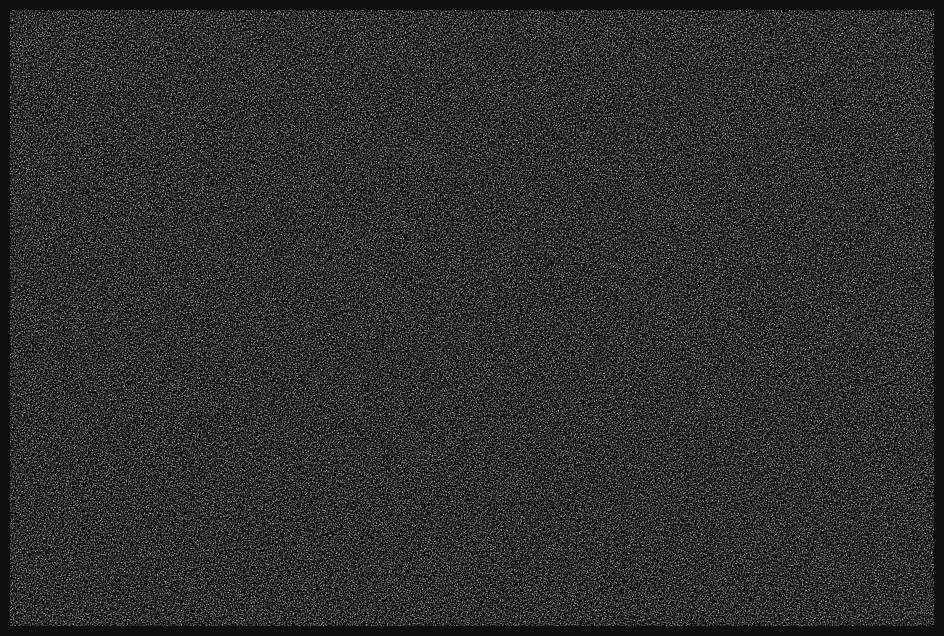

In [5]:
img_rgb1 = read_img('test_pic1.jpg')
img_hls = rgb_to_hls(img_rgb1)

# we choose what we hope are reasonable values
grain_size = 1.5
intensity = 0.4
offset = 0.0

noise = noise2array(
	np.linspace(0, img_hls.shape[1]/grain_size , num=img_hls.shape[1]),
	np.linspace(0, img_hls.shape[0]/grain_size, num=img_hls.shape[0])
) * intensity + offset

# quickly check the stats of our noise
print('noise max:', round(noise.max(), 2))
print('noise min:', round(noise.min(), 2))
print('noise mean:', round(noise.mean(), 2))

# don't forget that we have values going below 0.0 that are getting clipped on output!
show_img_gray(noise)

Now, we do what we did earlier and create another color response curve, but this time it applies the granular noise with respect to the image's tonality. Typically, we see more noise in darker regions, so lets set our response curve to match that.

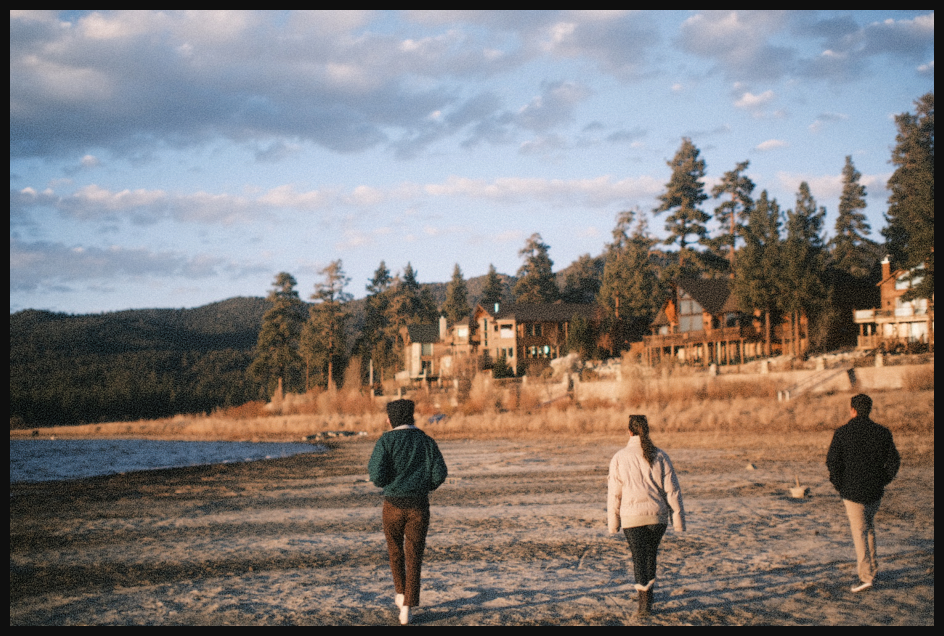

In [13]:
img_hls = rgb_to_hls(img_rgb1) # reset our img_hls

tone_response_data_x = [0.0, 0.25, 0.5, 0.75, 1.0]
tone_response_data_y = [0.25, 0.5, 0.2, 0.1,  0.1] # greater response in the shadows
# color response with respect to luminosity, i.e. tone
f_tone_response_curve = interp1d(tone_response_data_x, tone_response_data_y, kind='cubic')
plot_tone_curve(tone_response_data_y, f_tone_response_curve, label='tone response')

img_hls[:, :, 1] = img_hls[:, :, 1] + f_tone_response_curve(img_hls[:, :, 1]) * noise
img_out = hls_to_rgb(img_hls)

show_img_rgb(img_out)

# # the grain is hard to see in a low resolution notebook preview. You may want to save the file with the line below.
# write_img(img_out, 'test_pic1_grain.jpg')

Looking good! The next feature on our list is halation. 

Put simply, halation is red fringing caused by backscattering in the film emulsion. We're going to emulate it by thresholding the red channels' brightest pixels, diffusing it with a gaussian blur, and then adding it on top of the original image.


$$
R_\alpha = \mathrm{threshold\_curve}(R) \\
R' = R + \mathrm{gaussian}(\mathrm{radius}, \, R_\alpha) \times \mathrm{opacity}
$$

We also give the option to for strength of the effect by multiplying by $\mathrm{opacity}$. We'll output some intermediate steps to show how this all comes together.

Text(0.5, 1.0, 'rescale opacity')

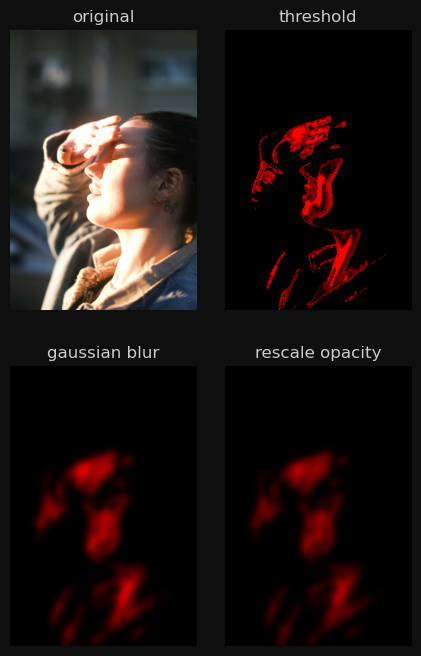

In [14]:
# we should use a new image that has stronger highlights and contrast to better display the effect
img_rgb2 = read_img('test_pic2.jpg') 

# set our parameters
radius = 20
opacity = 0.8

# pass only the *highest* intensity pixels
threshold_data_x = [0.0, 0.99, 1.0] 
threshold_data_y = [0.0, 0.0, 1.0]
f_threshold_curve = interp1d(threshold_data_x, threshold_data_y, kind='linear') # we don't need a fancy cubic to threshold; let's just go linear

# threshold on red channel
r_alpha = f_threshold_curve(img_rgb2[:, :, 0]) 

# this process is a bit more complicated so we'll look at intermediate steps
r_alpha_mask = np.zeros(img_rgb2.shape, dtype=np.float32) # make a copy of the image with the right shape
r_alpha_mask[:, :, 0] = r_alpha

gaussian_mask = np.zeros(img_rgb2.shape, dtype=np.float32)
gaussian_mask[:, :, 0] = gaussian_filter(r_alpha_mask[:, :, 0], radius) # blur it

rescaled  = np.zeros(img_rgb2.shape, dtype=np.float32)
rescaled[:, :, 0] = gaussian_mask[:, :, 0] * opacity # apply opacity scaling

# # # visualization code # # #
# what our threshold curve looks like
plot_thresh_curve(threshold_data_x, threshold_data_y, f_threshold_curve)
fig, axarr = plt.subplots(2, 2)
fig.set_facecolor('#0f0f0f')
fig.subplots_adjust(wspace = -0.7)
axarr[0, 0].imshow(img_rgb2); axarr[0, 0].axis('off'); axarr[0, 0].set_title('original', color='#CCCCCC') 
axarr[0, 1].imshow(r_alpha_mask); axarr[0, 1].axis('off'); axarr[0, 1].set_title('threshold', color='#CCCCCC') 
axarr[1, 0].imshow(gaussian_mask); axarr[1, 0].axis('off'); axarr[1, 0].set_title('gaussian blur', color='#CCCCCC') 
axarr[1, 1].imshow(rescaled); axarr[1, 1].axis('off'); axarr[1, 1].set_title('rescale opacity', color='#CCCCCC') 

Okay now let's actually add the `rescale opacity` on top of the original image and see the outcome.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


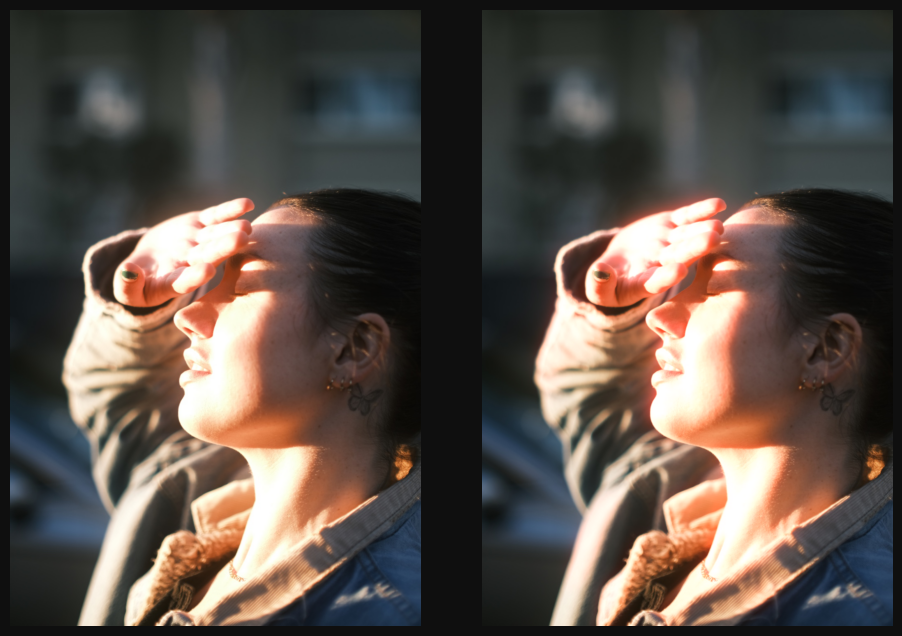

In [8]:
img_out = img_rgb2.copy() # make a copy so we can see before and after
img_out[:, :, 0] = img_rgb2[:, :, 0] + opacity * (gaussian_filter(img_rgb2[:, :, 0] * r_alpha, radius))

show_img_left_right(img_rgb2, img_out)

## Conclusion

Between these first two devblogs, we've accomplished all the major features we wanted to hit--and it looks quite good! Still, two things stick out during this process:

1. There are so many parameters to adjust! If we want to select the best values for our artistic expression, we need a proper GUI with sliders and all.
2. This Python code, while easy to read, is kind of slow! It would be ideal to use a faster language and/or hardware acceleration. That way, we could see the updates from the GUI in real time.

Well, we will explore both of these issues in the coming devblogs. We'll dive into how to use D3.js and svelte to make a a reactive GUI component, and how to use WebGL 2.0 and shaders to utilize our GPU.

## Appendix

As with any good technical writeup, we need to quickly cover the rough edges we glossed over.


### Luminosity vs. tonality

I've been fast and loose with my usage of the terms luminosity and tonality. Luminosity has a very specific meaning in how it affects the HSL color space, but tonality is more of an umbrella term in that it's just a different shade of the same color, i.e. lighter or darker. When I use the term tone, I'm usually referring to the RGB intensity together in unison, rather than the L in HSL.

You could argue that luminosity and value are both ways of describing tonality. And that's important, because Filmic currently (as of v0.3) uses HSV and our examples in this article are all HSL.


### Halation is complicated

Halation has a lot of nuances we haven't capture in our example:

- distribution of halation isn't necesarrily gaussian
- it isn't always dispersed pure red, i.e. need hue adjustment
- because we're working with clipped data, our application is imperfect and can cause excess saturation with additive methods
- halation isn't so different from bloom; can we exploit this for efficiency if we want bloom as a feature too?

There's a lot more in this I need to explore, and will do so in its own article. Until I've figured it out, I'm leaving it out of filmic.


## Thanks

If you find any typos, other errors, or want to make a comment, please contact me. And of course, feel free to reuse and remix any of this code. Please don't publicly repost these photos though! Only because they're my friends' likeness. Thanks!